<a href="https://colab.research.google.com/github/itzelts/2025-AM158-PSETS/blob/main/AM158_PSET2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem set 2 - Monte Carlo method & TD learning

**Due: 11:59pm, October 10, 2025**

### Problem 1 - Monte Carlo evaluation and Monte Carlo control (Coding).

TODO list:

- (1) Finish MC Policy Evaluation Code (10 pt)
- (2) Try different step size and discuss (10 pt)
- (3) Finish MC + Exploring Starts Code (10 pt)
- (4) Plot the convergence behavior, discuss the plot (10 pt)
- (5) Proof of Monte-Carlo control on *random walk* problem (20 pt)
- (6) Finish MC + epsilon greedy Code (10 pt)


<!-- - MC Policy Evaluation Code (long runtime)
- MC Policy Evaluation Different Step size plot
- MC + Exploring Starts Code (long run time)
- MC + ES Observe Plot, describe observation
- MC + ES proof
- MC + epsilon greedy code  -->

### Problem 2 - Temporal-difference evaluation, SARSA and Q-learning
- (1) Finish TD evaluation Code (10 pt)
- (2) Finish SARSA algorithm (10 pt)
- (3) Finish Q-learning algorithm (10 pt)


<!-- - TD Evaluation
- SARSA
- Q-Learning -->


## Problem 1: Monte-Carlo method on CliffWalk environment.

Recall from last PSET, the **CliffWalking** gridworld is a 4×12 grid. The agent starts at the bottom-left cell and aims to reach the bottom-right. The bottom row between start and goal is a **cliff**; stepping into it ends the episode with a large penalty. Each non-terminal step yields −1; stepping into the cliff yields −100 (and termination).  

In this problem we will **directly use Gym/Gymnasium** to interact with the environment (`CliffWalking-v1`) and perform **Monte-Carlo (MC) method**. Here we provide the print utility function as the same in PSET 1.


In [1]:
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----- Reproducibility -----
seed = 0
np.random.seed(seed)          # numpy RNG (env seeding can be done at reset time)

# ----- Environment -----
env = gym.make("CliffWalking-v1")  # 4x12 grid; bottom row is cliff + goal

# Pretty printing for small numeric tables
np.set_printoptions(precision=3, suppress=True)

def print_values(values, nrow: int, ncol: int, title: str = "State Values"):
    """
    Print a value table V in grid form.
    """
    values = np.asarray(values).reshape(nrow, ncol)
    print(title)
    for r in range(nrow):
        print(" ".join(f"{values[r, c]:6.2f}" for c in range(ncol)))
    print()

def print_policy(pi, nrow: int, ncol: int, title: str = "Policy"):
    """
    Render a policy on the CliffWalking grid as arrows.

    The environment uses the action indexing:
        0 = UP, 1 = RIGHT, 2 = DOWN, 3 = LEFT
    """
    arrow = {0: "^", 1: ">", 2: "v", 3: "<"}  # matches env action semantics
    print(title)
    for i in range(nrow):
        row_syms = []
        for j in range(ncol):
            s = i * ncol + j
            p = pi[s]

            # Determine greedy action(s)
            if isinstance(p, list) and len(p) == 4:
                best = np.argwhere(np.array(p) == np.max(p)).flatten().tolist()
            elif isinstance(p, int):
                best = [p]
            else:
                arr = np.array(p, dtype=float).ravel()
                best = np.argwhere(arr == np.max(arr)).flatten().tolist()

            # Cliff/goal cells (bottom row except column 0) rendered as terminal
            if i == nrow - 1 and j > 0:
                row_syms.append("T")
            else:
                row_syms.append("".join(arrow[a] for a in best))
        print(" ".join(sym if sym else "." for sym in row_syms))
    print()

# ----- Reference table (ground-truth under random policy from PSET1) -----
# Shape is (4, 12) in row-major order, then flattened to 1D for convenience.
# Values correspond to the state-value function V^π for the UNIFORM RANDOM policy.
V_random_gt = np.array([
    [-143.21, -147.36, -151.35, -153.93, -155.11, -155.05, -153.66, -150.44, -144.43, -134.39, -119.88, -105.06],
    [-164.99, -174.34, -180.41, -183.52, -184.80, -184.82, -183.62, -180.68, -174.67, -162.95, -141.20, -108.16],
    [-207.96, -237.09, -246.20, -249.36, -250.43, -250.52, -249.79, -247.81, -243.17, -231.62, -199.35,  -96.76],
    [-261.35,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00],
], dtype=float).flatten()


### 1.1 Monte-Carlo evaluation

Let $\mathcal{D}(s)$ denote the set of all time indices at which state $s$ is visited across sampled episodes. Then the Monte Carlo estimate of the value function is
$$
\hat{V}(s)=\frac{1}{|\mathcal{D}(s)|}\sum_{t\in \mathcal{D}(s)} g_t .
\tag{2.3}
$$

There are two common variants:

- **First-visit MC:** use only the first occurrence of $s$ in each episode.
- **Every-visit MC:** use all occurrences of $s$ within an episode.

You can test both of them in 1.2. For 1.1 you need to finish the **first-visit** one.

**TODO: Finish the code block for monte-carlo evaluation.**


MC first-visit: 100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


Estimated State Values (MC First-Visit)
-140.15 -146.96 -153.21 -150.54 -150.18 -151.46 -145.24 -145.79 -138.16 -131.94 -115.62 -109.69
-161.99 -174.23 -177.95 -186.39 -181.29 -179.88 -169.60 -174.75 -169.39 -160.08 -138.01 -111.31
-204.44 -235.09 -242.58 -245.57 -245.82 -250.84 -238.17 -238.55 -234.76 -223.99 -204.68 -98.21
-254.46   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



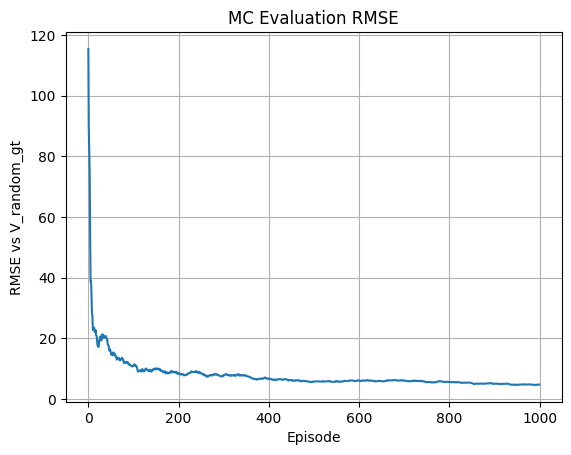

In [2]:
def mc_evaluate(policy, env, episodes=5000, gamma=0.95, seed=None):
    """
    First-visit Monte Carlo (MC) state-value prediction (Sutton & Barto, Alg. 5.1).

    Parameters
    ----------
    policy : ndarray, shape (nS, nA)
        Row-stochastic policy: for each state s, policy[s] is a prob. dist. over actions.
    env : Gymnasium-like environment
        Must expose discrete observation_space.n and action_space.n and return
        (obs, reward, terminated, truncated, info) from step().
    episodes : int
        Number of episodes to sample.
    gamma : float
        Discount factor in [0, 1].
    seed : int | None
        If given, used to seed a NumPy RNG and (re)seed env at each episode start.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float)          # value estimates
    N_first = np.zeros(nS, dtype=int)      # first-visit counts per state
    visits = np.zeros(nS, dtype=int)       # total visits (diagnostic only)
    errors = []

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc="MC first-visit"):
        # Episode generation under π
        s, _ = env.reset(seed=int(rng.integers(1e9)) if seed is not None else None)
        states, rewards = [], []
        done = False

        while not done:
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            ##########################################
            # record the state encountered at this time step
            states.append(s)
            visits[s] += 1

            # sample action from the given stochastic policy
            a = rng.choice(nA, p=policy[s])

            # step environment
            s_next, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)

            s = s_next
            done = terminated or truncated

        # Identify first visits of each state in this episode
        first_visit_mask = [False] * len(states)
        seen_from_start = set()
        for t, st in enumerate(states):
            if st not in seen_from_start:
                seen_from_start.add(st)
                first_visit_mask[t] = True

        # Backward return accumulation; update ONLY on first visits
        ##########################################
        # TODO: update V and N_first for first-visit states
        ##########################################
        G = 0.0
        for t in reversed(range(len(states))):
            G = rewards[t] + gamma * G
            s_t = states[t]
            if first_visit_mask[t]:
                N_first[s_t] += 1
                # sample-average incremental update
                V[s_t] += (G - V[s_t]) / N_first[s_t]

        # Track RMSE to a reference table for the random policy (from PSET1)
        rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
        errors.append(rmse)

    return V, errors


# Uniform-random policy for evaluation
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

V, errors = mc_evaluate(policy, env, episodes=1000)

print_values(V, 4, 12, "Estimated State Values (MC First-Visit)")
# Compare visually with PSET1 reference; they should be close (up to sampling noise).

plt.figure()
plt.plot(errors)
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.title("MC Evaluation RMSE")
plt.grid(True)
plt.show()

# Note: On my laptop this may take ~1 minute for 1k episodes, depending on Python + Gym versions.

### 1.2 Plot for different step size.

Recall equation (2.4) in the lecture note:
$$
\hat{V}(s) \leftarrow \hat{V}(s) + \alpha_{N(s)}\!\left(g_t - \hat{V}(s)\right),
\qquad \alpha_{N(s)} > 0 \text{ diminishing.}
$$

For standard Monte-Carlo evaluation, you will take the $\alpha_{N(s)}$ as $\frac{1}{N(s)}$. But you have more options: you can do constant step or other steps you prefer.

**TODO: test different step size options (sample average, constant step size with different values, and another step size schedule that satisfies Robbins-Monro), and you can also change first-visit to every-visit. What do you observe?**

Hint: you can try save different loss curves and plot in the same plot

MC (rm, FV): 100%|██████████| 2000/2000 [08:16<00:00,  4.03it/s]


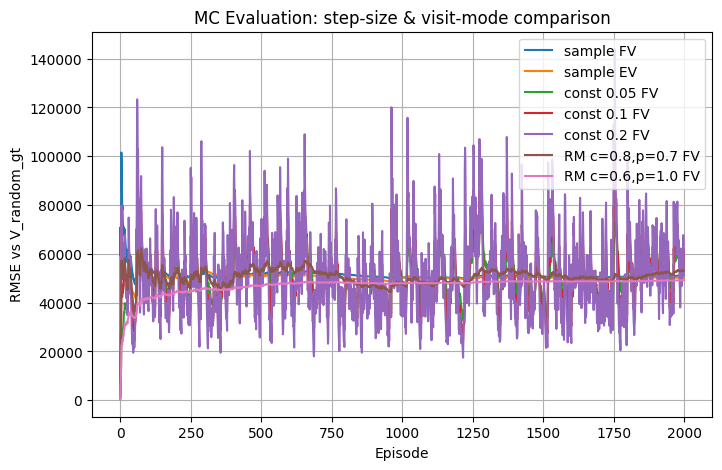

In [15]:
# def mc_evaluate(
#     policy,
#     env,
#     episodes=2000,
#     gamma=1.0,
#     seed=0,
#     step_mode="sample",     # "sample" | "constant" | "rm"
#     alpha=0.1,              # used when step_mode="constant"
#     rm_params=(0.5, 10.0, 0.75),  # (c, t0, p) for rm: c/(n+t0)^p
#     every_visit=False,      # false = first-visit or true = every-visit
# ):
#     nS, nA = env.observation_space.n, env.action_space.n
#     V = np.zeros(nS, dtype=float)
#     errors = []

#     # per-state counters used for step sizes that depend on N(s)
#     N = np.zeros(nS, dtype=int)

#     rng = np.random.default_rng(seed)

#     for ep in tqdm(range(episodes), desc=f"MC ({step_mode}, {'EV' if every_visit else 'FV'})"):
#         s, _ = env.reset(seed=int(rng.integers(1e9)))
#         states, rewards = [], []
#         done = False
#         while not done:
#             states.append(s)
#             a = rng.choice(nA, p=policy[s])
#             s, r, terminated, truncated, _ = env.step(a)
#             rewards.append(r)
#             done = terminated or truncated

#         # mark first visits if needed
#         first_visit_mask = [False] * len(states)
#         if not every_visit:
#             seen = set()
#             for t, st in enumerate(states):
#                 if st not in seen:
#                     seen.add(st)
#                     first_visit_mask[t] = True
#         else:
#             # every-visit = update at all time indices
#             first_visit_mask = [True] * len(states)

#         # backward return accumulation & updates
#         G = 0.0
#         c, t0, p = rm_params
#         for t in reversed(range(len(states))):
#             G = rewards[t] + gamma * G
#             s_t = states[t]
#             if first_visit_mask[t]:
#                 # choose step size alpha depending on mode
#                 if step_mode == "sample":
#                     N[s_t] += 1
#                     alpha_t = 1.0 / N[s_t]  # sample-average
#                 elif step_mode == "constant":
#                     alpha_t = alpha # fixed
#                 elif step_mode == "rm":
#                     N[s_t] += 1
#                     alpha_t = c / ((N[s_t] + t0) ** p) # rmschedule
#                 else:
#                     raise ValueError("Unknown step_mode")

#                 V[s_t] += alpha_t * (G - V[s_t])  # incremental MC update

#         rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
#         errors.append(rmse)

#     return V, np.array(errors)

# policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

# curves = {}

# # sample-average FV
# _, curves["sample FV"] = mc_evaluate(policy, env, episodes=2000, gamma=1.0,
#                                      step_mode="sample", seed=0, every_visit=False)

# # sample-average EV
# _, curves["sample EV"] = mc_evaluate(policy, env, episodes=2000, gamma=1.0,
#                                      step_mode="sample", seed=0, every_visit=True)

# # constant (several values), FV
# for a in [0.05, 0.1, 0.2]:
#     _, curves[f"const {a} FV"] = mc_evaluate(policy, env, episodes=2000, gamma=1.0,
#                                              step_mode="constant", alpha=a, seed=0, every_visit=False)

# # rm, FV with 1/2 < p ≤ 1
# for (c, t0, p) in [(0.8, 10.0, 0.7), (0.6, 10.0, 1.0)]:
#     _, curves[f"RM c={c},p={p} FV"] = mc_evaluate(policy, env, episodes=2000, gamma=1.0,
#                                                   step_mode="rm", rm_params=(c, t0, p), seed=0, every_visit=False)

# plt.figure(figsize=(8,5))
# for label, err in curves.items():
#     plt.plot(err, label=label)
# plt.xlabel("Episode")
# plt.ylabel("RMSE vs V_random_gt")
# plt.title("MC Evaluation: step-size & visit-mode comparison")
# plt.grid(True); plt.legend()
# plt.show()


In [17]:
# print("V range:", V.min(), V.max())
# print("V_random_gt range:", V_random_gt.min(), V_random_gt.max())
# print("shapes:", V.shape, V_random_gt.shape)
# print("RMSE[0..5]:", errors[:5])


V range: -9.73315833440937 0.0
V_random_gt range: -261.35 0.0
shapes: (48,) (48,)
RMSE[0..5]: [115.43720541033156, 89.0706430911054, 82.3736721962469, 74.47255398185887, 53.407904272965034]


MC (rm, FV): 100%|██████████| 2000/2000 [08:14<00:00,  4.04it/s]


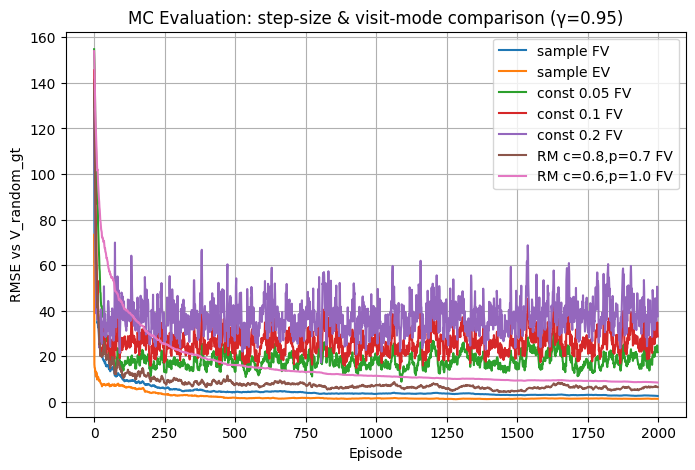

In [18]:
GAMMA = 0.95

def mc_evaluate(
    policy,
    env,
    episodes=2000,
    gamma=GAMMA,
    seed=0,
    step_mode="sample",     # "sample" | "constant" | "rm"
    alpha=0.1,              # used when step_mode="constant"
    rm_params=(0.5, 10.0, 0.75),  # (c, t0, p) for rm: c/(n+t0)^p, with 1/2 < p ≤ 1
    every_visit=False,      # False = first-visit, True = every-visit
):
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float)
    errors = []

    # per-state counters for step sizes that depend on N(s)
    N = np.zeros(nS, dtype=int)

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc=f"MC ({step_mode}, {'EV' if every_visit else 'FV'})"):
        s, _ = env.reset(seed=int(rng.integers(1e9)))
        states, rewards = [], []
        done = False
        while not done:
            states.append(s)
            a = rng.choice(nA, p=policy[s])
            s, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)
            done = terminated or truncated

        # --- first-visit vs every-visit mask ---
        if every_visit:
            first_visit_mask = [True] * len(states)
        else:
            seen = set()
            first_visit_mask = [False] * len(states)
            for t, st in enumerate(states):
                if st not in seen:
                    seen.add(st)
                    first_visit_mask[t] = True

        # --- backward return accumulation & incremental MC updates ---
        G = 0.0
        c, t0, p = rm_params
        for t in reversed(range(len(states))):
            G = rewards[t] + gamma * G
            s_t = states[t]
            if first_visit_mask[t]:
                if step_mode == "sample":
                    N[s_t] += 1
                    alpha_t = 1.0 / N[s_t]          # sample-average
                elif step_mode == "constant":
                    alpha_t = float(alpha)          # constant step size
                elif step_mode == "rm":
                    N[s_t] += 1
                    alpha_t = c / ((N[s_t] + t0) ** p)  # rm schedule
                else:
                    raise ValueError("Unknown step_mode")

                V[s_t] += alpha_t * (G - V[s_t])

        # RMSE against the provided table
        rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
        errors.append(rmse)

    return V, np.array(errors)



policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

curves = {}

# sample-average FV
_, curves["sample FV"] = mc_evaluate(
    policy, env, episodes=2000, gamma=GAMMA,
    step_mode="sample", seed=0, every_visit=False
)

# sample-average EV
_, curves["sample EV"] = mc_evaluate(
    policy, env, episodes=2000, gamma=GAMMA,
    step_mode="sample", seed=0, every_visit=True
)

# constant (several values), FV
for a in [0.05, 0.1, 0.2]:
    _, curves[f"const {a} FV"] = mc_evaluate(
        policy, env, episodes=2000, gamma=GAMMA,
        step_mode="constant", alpha=a, seed=0, every_visit=False
    )

# rm schedules, FV
for (c, t0, p) in [(0.8, 10.0, 0.7), (0.6, 10.0, 1.0)]:
    _, curves[f"RM c={c},p={p} FV"] = mc_evaluate(
        policy, env, episodes=2000, gamma=GAMMA,
        step_mode="rm", rm_params=(c, t0, p), seed=0, every_visit=False
    )

plt.figure(figsize=(8,5))
for label, err in curves.items():
    plt.plot(err, label=label)
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.title("MC Evaluation: step-size & visit-mode comparison (γ=0.95)")
plt.grid(True)
plt.legend()
plt.show()


We compared first-visit (FV) vs. every-visit (EV) Monte Carlo with several step-size rules like
sample-average $\alpha_{N(s)}=1/N(s)$, constant $\alpha\in\{0.05,0.1,0.2\}$, and Robbins Monro (RM)
schedules $\alpha_n = \tfrac{c}{(n+t_0)^p}$.


Sample-average (FV) converges steadily with low variance, but its early learning is moderate because $\alpha$ decays as $1/N(s)$.
Sample-average (EV) improves faster early than FV (lower variance targets
from using all visits) and attains slightly lower long-run RMSE.
Constant alpha learns quickly at the start but plateaus with higher variance. Larger $\alpha$ reduces initial error faster but yields noisier asymptotics .
RM give a compromise. We see faster early decrease than $1/N$ with eventual variance damping. Smaller $p$ ($0.7$) adapts faster
but is noisier than $p=1.0$.



### 1.3 Monte-Carlo control with Exploring Starts

In the class we talk about two methods to ensure exploration: exploring starts and $\epsilon$-greedy policy. We will start with exploring starts for monte-carlo control.

**TODO: finish code of Monte-Carlo control with exploring starts**.

In [5]:
def _set_state(env, s):
    """Attempt to set the environment's internal discrete state to `s`
    (needed for Exploring Starts).
    """
    try:
        # Many classic-control/grid envs expose `unwrapped.s`
        env.unwrapped.s = s
        return True
    except Exception:
        # Some variants use `.state` instead
        try:
            env.unwrapped.state = s
            return True
        except Exception:
            return False


def mc_control_exploring_starts(env, episodes=5000, gamma=0.95, max_steps=500, alpha=None):
    """
    Monte Carlo control with Exploring Starts (ES).  See Sutton & Barto, Alg. 5.3.

    Procedure
    ---------
    1) For each episode, sample an initial state–action pair (S0, A0) at random so that
       every (s, a) has nonzero probability.
    2) Roll out the *entire* episode under the current policy π (use A0 at t=0; thereafter
       sample actions from π).
    3) At the end of the episode, perform **first-visit** MC updates to Q(s, a) using the
       return G from each first-visited (s, a).
    4) For all states visited in this episode, improve the policy greedily:
       π(s) ← argmax_a Q(s, a) (break ties uniformly).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    N_visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    # Initialize π arbitrarily: start with a uniform distribution over actions.
    policy = np.ones((nS, nA), dtype=float) / nA

    for ep in tqdm(range(episodes), desc="MC ES (Exploring Starts)"):
        # --- Exploring Start: choose (S0, A0) uniformly at random ---
        # For CliffWalking we avoid terminal/cliff cells by excluding the last row
        # except the start (index 36). `nS - 11` ensures s0 ∈ {0..36}.
        s0 = np.random.randint(nS - 11)
        a0 = np.random.randint(nA)

        # Reset env, then force the start state to s0. If not supported, ES cannot be run strictly.
        s, _ = env.reset()
        if not _set_state(env, s0):
            raise RuntimeError(
                "Environment does not support setting arbitrary start states; "
                "strict Exploring Starts is not possible."
            )

        # --- Generate a full trajectory under current π (A0 at t=0, then follow π) ---
        states, actions, rewards = [], [], []
        s = s0
        a = a0
        done = False

        # Cap length to avoid pathological loops when π does not reach a terminal.
        for _ in range(max_steps):
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            ##########################################
            states.append(s)
            actions.append(a)

            s_next, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)

            s = s_next
            done = terminated or truncated

            if done:
                break

            # from t>=1, follow current policy
            a = np.random.choice(nA, p=policy[s])

        # --- First-visit masks for (s, a) within this episode ---
        first_visit_sa_mask = [False] * len(states)
        seen_from_start_sa = set()
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen_from_start_sa:
                seen_from_start_sa.add((st, at))
                first_visit_sa_mask[t] = True

        # --- Backward return accumulation; update Q only at first visits ---
        ##########################################
        # TODO: update Q and N_first for first-visit states
        ##########################################
        G = 0.0
        for t in reversed(range(len(states))):
            G = rewards[t] + gamma * G
            s_t, a_t = states[t], actions[t]
            if first_visit_sa_mask[t]:
                if alpha is None:
                    # sample-average step size
                    N_visits[s_t, a_t] += 1
                    alpha_t = 1.0 / N_visits[s_t, a_t]
                else:
                    alpha_t = alpha  # constant step size

                Q[s_t, a_t] += alpha_t * (G - Q[s_t, a_t])



        # --- Greedy policy improvement on states encountered this episode (uniform tie-breaking) ---
        ##########################################
        # TODO: update policy to be greedy wrt. Q for states visited in this episode
        ##########################################
        for s_visited in set(states):
            q_row = Q[s_visited]
            max_q = np.max(q_row)
            best_as = np.flatnonzero(q_row == max_q)
            policy[s_visited] = 0.0
            policy[s_visited, best_as] = 1.0 / len(best_as)


        # Keep a few early snapshots of V(s) for quick diagnostics
        if (ep % 100) == 0 and ep <= 10000:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


policy_es, Q_es, V_snaps = mc_control_exploring_starts(env, episodes=200000, gamma=0.95)

V_es = (policy_es * Q_es).sum(axis=1)
print_values(V_es, 4, 12, "V from MC-ES policy")
print_policy(policy_es, 4, 12, "MC-ES derived policy")

# Note: With 200k episodes this can take around a minute on a typical laptop
# (depends on Python/Gym versions and hardware).


MC ES (Exploring Starts): 100%|██████████| 200000/200000 [02:51<00:00, 1168.90it/s]

V from MC-ES policy
-10.39  -9.80  -9.28  -8.86  -8.04  -7.41  -6.74  -6.04  -5.30  -4.53  -3.71  -2.85
 -9.89  -9.38  -8.83  -8.07  -7.40  -6.73  -6.03  -5.30  -4.53  -3.71  -2.85  -1.95
 -9.33  -8.71  -8.13  -7.50  -6.85  -6.04  -5.30  -4.52  -3.71  -2.85  -1.95  -1.00
-10.49   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC-ES derived policy
v > > > v > > v v > > v
> > v > > > > v > > v v
> > > > > > > > > > > v
^ T T T T T T T T T T T



### 1.4 Convergence behavior

Use the `V_snap` you get from Monte-Carlo control to plot the convergence evolution.

**TODO: what do you observe form the plot?**

Hint: which part converge first?

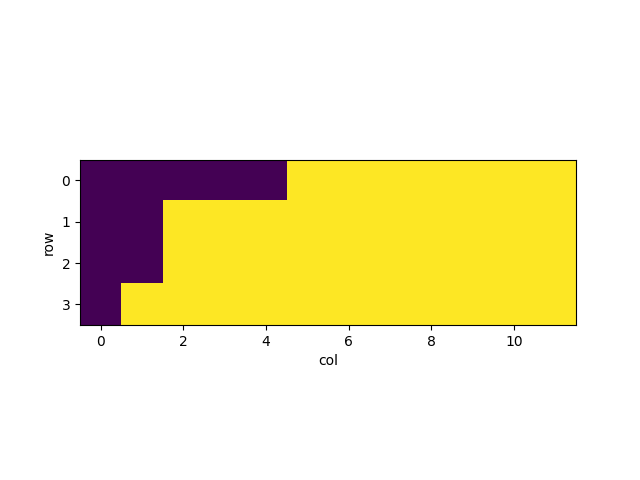

Saved GIF to: ./mc_es_grid_evolution.gif


In [6]:
import matplotlib.animation as animation
from IPython.display import Image, display

# Basic check
V_snaps = [np.asarray(v).ravel() for v in V_snaps]
K = int(V_snaps[0].size)
if K != 48:
    raise ValueError(f"Expected V.size == 48 to reshape into 4x12, but got {K}.")

# Fixed color scale to avoid per-frame jumps (do not specify a colormap; use defaults)
V_all = np.vstack(V_snaps)
vmin, vmax = -20, 0

# Initialize figure: 2D grid
fig, ax = plt.subplots()
grid0 = V_snaps[0].reshape(4, 12)
im = ax.imshow(grid0, vmin=vmin, vmax=vmax)  # Do not specify cmap
ax.set_xlabel("col")
ax.set_ylabel("row")

def init():
    im.set_data(grid0)
    return (im,)  # blit requires a tuple

def update(i):
    grid = V_snaps[i].reshape(4, 12)
    im.set_data(grid)
    return (im,)

ani = animation.FuncAnimation(
    fig, update, frames=len(V_snaps), init_func=init, blit=True, interval=400, repeat=False
)

gif_path = "./mc_es_grid_evolution.gif"
ani.save(gif_path, writer="pillow")
plt.close(fig)

display(Image(filename=gif_path))
print("Saved GIF to:", gif_path)

# Print the last frame as a 4x12 grid
V_last = V_snaps[-1].reshape(4, 12)
np.set_printoptions(precision=2, suppress=True)  # Pretty printing

Values near the goal and cliff edge converge first. Their returns have short horizons (few steps to termination) or strong signals (the (-100) cliff), so Monte-Carlo targets there have low variance and stabilize quickly. Then we see a “backward wave” of convergence along the safe corridor. States far from the goal,especially the start, converge last because their returns span many steps and are higher-variance.


### 1.5 Random walk on a ring: Why can monte-carlo method works? (Pen and Paper)

In this problem you will use a random walk problem to analyze the convergence behavior of Monte-Carlo control.

Consider a 1-D random walk problem on a ring, and one of them is the terminal state. Assume states are $\{0,1,2,...,K - 1\}$, and $0$ is the terminal state. The transition model can be written as $x_{k+1} = \text{mod}(x_k + u_k)$ where $u_k = -1 / 1$.

**Setup.**  
States $ \mathcal S=\{0,1,\dots,K-1\} $ with terminal $0$ (absorbing).  
Actions $ \mathcal A=\{-1,+1\} $, transition $ s'=(s+a)\bmod K $ (Note that terminal is absorb, so once it arrive $0$ it will not move).  
Per-step reward $-1$ until termination; discount $ \gamma\in(0,1] $.  
Distance to $0$: $ d(s)=\min\{s,K-s\} $.  
Algorithm: first-visit Monte-Carlo control with **Exploring Starts**.

**Claim.** With probability $1$, the learned policy converges to
$$
\pi^\star(s)=
\begin{cases}
\text{move to reduce } d(s), & d(s)\neq K/2,\\
\text{either action}, & d(s)=K/2 \text{ (if $K$ even),}
\end{cases}
$$
i.e., “go along the shortest arc to $0$”.

### Proof (outward induction on $d$)

First we write down the optimal value $V^\star$ under $\pi^\star$

**(a) TODO: write down $V^\star$**

**Answer:**
Under $\pi^\star$, starting from $s$, it takes exactly $d(s)$ steps to hit $0$ and then the episode ends.
The per-step reward is -1 until termination, so the optimal return is the discounted sum of d(s) copies of -1. Thus we have that
$$
V^\star(s)
=
-\sum_{t=0}^{d(s)-1}\gamma^{t}
=
\begin{cases}
-\dfrac{1-\gamma^{d(s)}}{1-\gamma}, & \gamma\in(0,1)\\
-d(s), & \gamma=1
\end{cases}
\qquad\text{with }V^\star(0)=0
$$

**Base of induction ($d=0$).**

**(b) TODO: Show that $Q(0,a)\equiv 0$**

**Answer:**
State $0$ is terminal and absorbing, so after entering $0$ all subsequent rewards are $0$.
Hence for any $a\in\mathcal A$,
$$
Q(0,a)
=\mathbb{E}\!\left[\sum_{t=0}^\infty \gamma^{t} r_{t+1} | s_0=0,\,a_0=a \right]
=0
$$
**Inductive hypothesis.** For every state with $d\le m-1$, the maximization of $Q(s,a)$ is already optimal, i.e.
$$
\max_a Q(s,a) := V(s) = V^\star
$$

**(c) TODO: For $d(s)=m$, show that $Q(s,\text{toward}) \geq Q(s,\text{away})$ (equality hold only when $s = \frac{K}{2}$)**

**Answer:**
Let $\text{toward}$ denote the action reducing distance, and $\text{away}$ the one increasing distance.
We write $s^\downarrow$ for the next state after taking $\text{toward}$ at $s$, and $s^\uparrow$ for the next state after taking $\text{away}$.

Then for toward, the next state  $s^\downarrow$ satisfies $d(s^\downarrow)=m-1$. So by one-step lookahead and the inductive hypothesis,
$$
Q(s,\text{toward})
= -1 + \gamma\,V(s^\downarrow)
= -1 + \gamma\,V^\star(s^\downarrow)
= -1 + \gamma\!\left(-\sum_{t=0}^{m-2}\gamma^{t}\right)
= -\sum_{t=0}^{m-1}\gamma^{t}
= V^\star(s)
$$

For away, if $m<K/2$, the next state  $s^\uparrow$ has $d(s^\uparrow)=m+1$ and afterwards the optimal behavior reduces distance. Thus we have
$$
Q(s, \text{away})
= -1 + \gamma V^\star(s^\uparrow)
= -1 + \gamma\left(-\sum_{t=0}^{m}\gamma^{t}\right)
= -\sum_{t=0}^{m+1}\gamma^{t}
$$
Therefore
$$
Q(s,\text{toward}) - Q(s,\text{away})
= \left(-\sum_{t=0}^{m-1}\gamma^{t}\right) - \left(-\sum_{t=0}^{m+1}\gamma^{t}\right)
= \gamma^{m} + \gamma^{m+1}
> 0 \quad(\gamma>0)
$$
Then $$
Q(s,\text{toward}) > Q(s,\text{away})$$
If $K$ is even and $s=K/2$, then $m =K/2$ and both neighbors have distance $m-1$, so both actions reduce distance and
$$Q\big(s,\text{toward}\big) = Q\big(s,\text{away}\big) = -\sum_{t=0}^{m-1}\gamma^{t}
$$
Thus $Q(s,\text{toward})\ge Q(s,\text{away})$ with equality only at the tie state $s=K/2$ (when $K$ is even).
//

Therefore greedy improvement sets $\pi(s)=\text{toward}$. By convergence of monte-carlo evaluation under fix policy, $Q(s,\text{toward})$ finally converge.

### 1.6 Monte-Carlo control with $\epsilon$-soft policies

**TODO: finish the code for Monte-Carlo control with $\epsilon$-soft policies**

In [9]:
def _epsilon_soft_from_Q(Q_row: np.ndarray, epsilon: float, tol: float = 1e-12) -> np.ndarray:
    """
    Build an ε-soft *greedy* action distribution from a vector of Q-values.

    Rule:
      1) Give every action a base mass ε/|A|.
      2) Split the remaining (1-ε) uniformly among the greedy (argmax) actions.
         (Deterministic tie-handling: no random tie-breaking.)
    """
    nA = Q_row.shape[0]
    probs = np.full(nA, epsilon / nA, dtype=float)

    m = Q_row.max()
    ties = np.flatnonzero(np.isclose(Q_row, m, atol=tol, rtol=0.0))
    share = (1.0 - epsilon) / ties.size
    probs[ties] += share
    return probs


def mc_control_onpolicy_epsilon_soft(
    env,
    episodes: int = 5000,
    gamma: float = 0.95,
    max_steps: int = 500,
    alpha: float | None = None,   # None → sample mean 1/N(s,a); else constant step-size
    epsilon: float = 0.1,         # constant ε if no schedule is provided
    eps_schedule=None,            # optional callable: eps = eps_schedule(ep)  (GLIE-style)
    min_epsilon: float = 0.0,
):
    """
    On-policy first-visit Monte Carlo control with ε-soft policies
    (Sutton & Barto, On-policy MC Control).

    Key differences from MC with Exploring Starts (ES):
      • No exploring starts; episodes are generated by the current ε-soft policy π.
      • Policy improvement *keeps* π ε-soft: greedy actions get (1-ε)+ε/|A|, others ε/|A|.
    """
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA), dtype=float)
    N_first = np.zeros((nS, nA), dtype=int)

    # Initialize π arbitrarily: uniform over actions (already ε-soft for any ε).
    policy = np.full((nS, nA), 1.0 / nA, dtype=float)

    ep_idx, V_snaps = [], []

    for ep in tqdm(range(episodes), desc="MC (ε-soft)"):
        # GLIE-style ε schedule (optional)
        eps = float(eps_schedule(ep)) if eps_schedule is not None else float(epsilon)
        eps = float(np.clip(eps, min_epsilon, 1.0))

        # ---- Generate one episode under current ε-soft policy π ----
        states, actions, rewards = [], [], []
        s, _ = env.reset()
        a = int(np.random.choice(nA, p=policy[s]))  # first action from current policy

        for _ in range(max_steps):
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            ##########################################
            states.append(s)
            actions.append(a)

            s_next, r, terminated, truncated, _ = env.step(a)
            rewards.append(r)

            s = s_next
            done = terminated or truncated

            if done:
              break

            a = int(np.random.choice(nA, p=policy[s]))

        # ---- First-visit markers for (s,a) within this episode ----
        seen = set()
        first_visit = [False] * len(states)
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen:
                seen.add((st, at))
                first_visit[t] = True

        # ---- Backward return accumulation; update Q only at first visits ----
        ##########################################
        # TODO: update Q and N_first for first-visit states
        ##########################################
        G = 0.0
        for t in reversed(range(len(states))):
            G = rewards[t] + gamma * G
            st, at = states[t], actions[t]
            if first_visit[t]:
                if alpha is None:
                    N_first[st, at] += 1
                    alpha_t = 1.0 / N_first[st, at]  # sample-average
                else:
                    alpha_t = alpha  # constant step-size
                Q[st, at] += alpha_t * (G - Q[st, at])


        # ---- ε-soft greedy policy improvement (only on states seen this episode) ----
        visited_states = set(states)
        for st in visited_states:
            policy[st] = _epsilon_soft_from_Q(Q[st], eps)

        # Light snapshots for convergence plots (every 100 eps)
        if (ep % 100) == 0:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


def eps_schedule(ep, c=2000.0, eps_min=0.01):
    """Simple GLIE schedule: ε_ep = max(eps_min, c / (c + ep))."""
    return max(eps_min, c / (c + ep))


policy, Q, V_snaps = mc_control_onpolicy_epsilon_soft(
    env,
    episodes=10000,
    gamma=0.95,
    epsilon=1.0,  # start fully exploratory; schedule will decay it
    eps_schedule=lambda ep: eps_schedule(ep, c=2000.0, eps_min=0.01),
    min_epsilon=0.0,
    alpha=0.01    # constant step-size for Q-updates (try None for 1/N(s,a))
)

V_soft = (policy * Q).sum(axis=1)
print_values(V_soft, 4, 12, "V from MC ε-soft policy")
print_policy(policy, 4, 12, "MC ε-soft derived policy")


MC (ε-soft): 100%|██████████| 10000/10000 [00:45<00:00, 221.01it/s]

V from MC ε-soft policy
-12.07 -11.57 -10.90 -10.34  -9.68  -9.00  -8.27  -7.51  -6.59  -5.70  -4.79  -4.18
-12.62 -13.24 -14.07 -13.13 -13.22 -12.63 -12.29 -11.55 -10.01  -8.29  -4.43  -2.53
-13.67 -21.03 -28.84 -35.76 -38.09 -39.25 -39.29 -37.83 -32.08 -26.34 -10.04  -1.46
-18.09   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC ε-soft derived policy
> > > > > > > > > > v v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ T T T T T T T T T T T



## Problem 2: SARSA & Q-learning on Cliffwalk environment

### 2.1 TD evaluation

**Algorithmic Form.** Suppose the agent is in state $s_t$, takes action $a_t \sim \pi(\cdot \mid s_t)$, receives reward $r_t$, and transitions to $s_{t+1}$. The TD(0) update rule is
$$
\hat V(s_t) \leftarrow \hat V(s_t) + \alpha\,[\,r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t)\,],
\tag{2.6}
$$
where $\alpha \in (0,1]$ is the learning rate.

The term inside the brackets,
$$
\delta_t = r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t),
\tag{2.7}
$$
is called the **TD error**.

**TODO: finish the code for TD evluation**

TD evaluation: 100%|██████████| 1000/1000 [02:26<00:00,  6.82it/s]


Estimated State Values (TD(0) evaluation)
-144.53 -148.07 -151.59 -153.98 -155.35 -156.83 -154.88 -150.97 -142.76 -134.58 -121.68 -107.45
-167.08 -176.90 -183.59 -186.58 -188.27 -184.76 -182.43 -174.51 -169.88 -164.34 -141.80 -110.73
-216.00 -253.63 -253.83 -254.22 -254.53 -253.79 -251.82 -240.40 -238.86 -233.60 -199.01 -101.55
-269.40   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



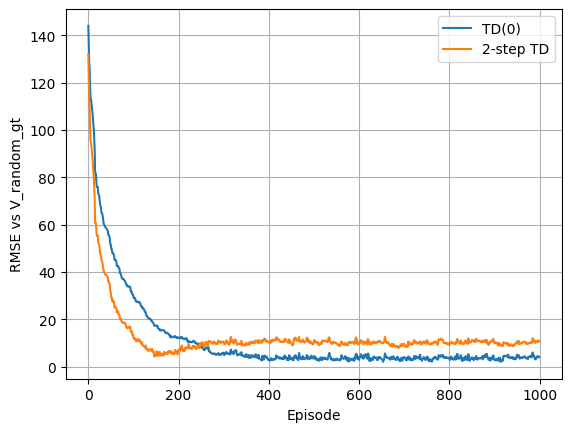

In [11]:
def td0_evaluate(env, episodes=5000, gamma=0.95, alpha=0.1, seed=None):
    """
    On-policy temporal-difference evaluation under a **uniform random policy**.

    Computes:
      • V_TD0 : TD(0) / 1-step bootstrap   V(s_t) ← V(s_t) + α [ r_t + γ V(s_{t+1}) − V(s_t) ]
      • V_TD2 : 2-step TD for the *previous* state s_{t-1}
                V(s_{t-1}) ← V(s_{t-1}) + α [ r_{t-1} + γ r_t + γ^2 V(s_{t+1}) − V(s_{t-1}) ]
                (This is the n=2 special case of n-step TD.)
    Returns V_TD0 and RMSE traces for both estimators vs the provided V_random_gt.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    policy = np.ones((nS, nA)) / nA

    V_TD0 = np.zeros(nS, dtype=float)
    V_TD2 = np.zeros(nS, dtype=float)

    visit_counts = np.zeros(nS, dtype=int)  # diagnostic only
    errors_1, errors_2 = [], []

    if seed is not None:
        np.random.seed(seed)

    for _ in tqdm(range(episodes), desc="TD evaluation"):
        s, _ = env.reset()
        done = False

        # Keep the previous transition to form a 2-step target
        prev_state = None      # will hold s_{t-1}
        prev_reward = None     # will hold r_{t-1}

        while not done:
            ##########################################
            # TODO: step the environment, update Q
            ##########################################
            # sample action from the uniform random policy
            # a = np.random.choice(nA, p=policy[s])
            a = np.random.randint(nA)

            # take a step
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # TD(0) update for current state s
            v_next = 0.0 if done else V_TD0[s_next]
            td_err = r + gamma * v_next - V_TD0[s]
            V_TD0[s] += alpha * td_err

            # 2-step TD update for the previous state (if exists)
            if prev_state is not None:
                v_next2 = 0.0 if done else V_TD2[s_next]
                target2 = prev_reward + gamma * r + (gamma ** 2) * v_next2
                V_TD2[prev_state] += alpha * (target2 - V_TD2[prev_state])

            # advance
            visit_counts[s] += 1
            prev_state, prev_reward = s, r
            s = s_next

        # Episode-level RMSE diagnostics
        errors_1.append(np.sqrt(np.mean((V_TD0 - V_random_gt) ** 2)))
        errors_2.append(np.sqrt(np.mean((V_TD2 - V_random_gt) ** 2)))

    return V_TD0, (errors_1, errors_2)


# Example run
V, (errors_1, errors_2) = td0_evaluate(env, episodes=1000, alpha=0.01)

print_values(V, 4, 12, "Estimated State Values (TD(0) evaluation)")

plt.figure()
plt.plot(errors_1, label="TD(0)")
plt.plot(errors_2, label="2-step TD")
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.grid(True)
plt.legend()
plt.show()

# Note: On my laptop this may take ~20s for 1k episodes


### 2.2 SARSA algorithm

In [12]:
def sarsa(
    env,
    episodes=5000,
    Q_init=None,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    On-policy SARSA(0) control for **tabular, discrete** Gymnasium environments.

    Behavior policy: ε-greedy w.r.t. current Q.
    Update rule (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ Q(s', a') − Q(s,a) ],
    where a' is sampled ε-greedily from state s' (on-policy).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = Q_init.copy() if Q_init is not None else np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: uniform random with prob ε; otherwise greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="SARSA control"):
        s, _ = env.reset()
        a = eps_greedy_action(s, epsilon)

        # (Optional) record of visited states; useful for debugging/plots.
        s_record = []

        for _ in range(max_steps):
            ##########################################
            # TODO: step the environment, update Q and choose action
            ##########################################
            # take action a
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            if done:
                # target = r  (since Q(s', a') = 0 at terminal)
                td_target = r
                Q[s, a] += alpha * (td_target - Q[s, a])
                visits[s, a] += 1
                s_record.append(s_next)
                break

            # choose next action a' on-policy
            a_next = eps_greedy_action(s_next, epsilon)

            # SARSA update
            td_target = r + gamma * Q[s_next, a_next]
            Q[s, a] += alpha * (td_target - Q[s, a])
            visits[s, a] += 1

            # move forward
            s, a = s_next, a_next
            s_record.append(s)

        # Lightweight snapshots early on (every 2 episodes up to 100)
        if (ep % 2) == 0 and ep <= 100:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, visits, V_snaps


Q, visits, V_snaps = sarsa(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after SARSA)")


SARSA control: 100%|██████████| 50000/50000 [00:49<00:00, 1016.43it/s]

State Values (greedy after SARSA)
 -9.53  -9.15  -8.70  -8.21  -7.68  -7.11  -6.51  -5.86  -5.18  -4.46  -3.68  -2.86
 -9.77  -9.23  -8.66  -8.06  -7.42  -6.75  -6.05  -5.32  -4.55  -3.73  -2.86  -1.95
-10.29  -9.66  -9.15  -8.64  -7.38  -6.30  -5.55  -4.77  -3.90  -2.93  -1.97  -1.00
-10.78   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



### 2.3 Q-learning algorithm

In [13]:
def q_learning(
    env,
    episodes=20000,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    Tabular **Q-learning** (off-policy, 1-step TD) control.

    Behavior policy: ε-greedy w.r.t. current Q (for exploration).
    Target policy:   greedy (max over actions in s')  — this is what makes it **off-policy**.

    Update (per step):
        Q(s,a) ← Q(s,a) + α [ r + γ * max_{a'} Q(s', a') − Q(s,a) ].
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)  # diagnostic: how often each (s,a) is updated
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: with prob ε pick random action; else greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)  # random tie-breaking argmax
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="Q-learning control"):
        s, _ = env.reset()

        for _ in range(max_steps):
            ##########################################
            # TODO: step the environment, update Q and choose action
            ##########################################
            a = eps_greedy_action(s, epsilon)

            # step environment
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # Q-learning target: greedy in s' (off-policy)
            if done:
                td_target = r # terminal
            else:
                td_target = r + gamma * np.max(Q[s_next])

            # update
            Q[s, a] += alpha * (td_target - Q[s, a])
            visits[s, a] += 1

            # move on or stop
            if done:
                break
            s = s_next

        # light snapshots early on (every 10 episodes up to 1k)
        if (ep % 10) == 0 and ep <= 1000:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, V_snaps


Q, V_snaps = q_learning(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after Q-learning)")


Q-learning control: 100%|██████████| 50000/50000 [00:44<00:00, 1130.98it/s]

State Values (greedy after Q-learning)
 -8.71  -8.43  -8.05  -7.60  -7.11  -6.57  -6.00  -5.40  -4.77  -4.11  -3.43  -2.76
 -8.97  -8.62  -8.17  -7.68  -7.14  -6.55  -5.91  -5.22  -4.48  -3.69  -2.85  -1.95
 -9.19  -8.62  -8.03  -7.40  -6.73  -6.03  -5.30  -4.52  -3.71  -2.85  -1.95  -1.00
 -9.73   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

